In [10]:
import sys
sys.path.append('../scripts/')

In [17]:
import itertools
import numpy as np

import torch
import torch.nn as nn
from matplotlib import pylab as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold

from train_helpers import train, gen_loaders
from constants import test_metrics, mlp_features_columns
from utilities import load_data, open_log, clip_features_inplace, transform_data

In [13]:
if not torch.cuda.is_available():
    print('WARNING: using CPU.')
    log.write('\tWARNING: using CPU.\n')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MLP and XGboost

## Data analysis

In [36]:
X, y = load_data()

plot the distribution of the dataset

In [37]:
plot_x = X
# plot_x = x_train
# plot_x = x_test

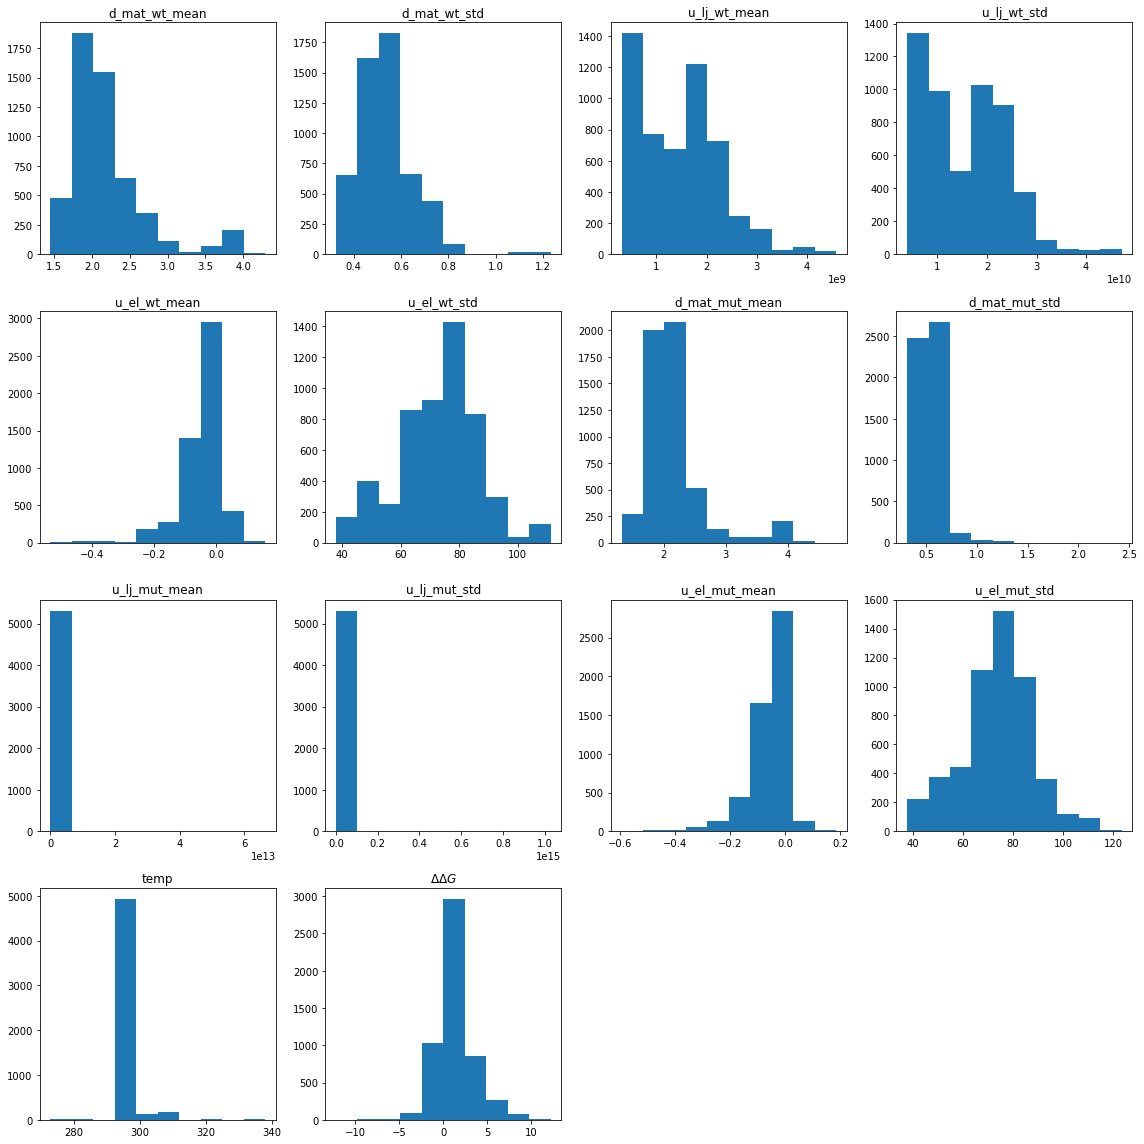

In [38]:
fig = plt.figure(figsize=(16,16))

N = len(mlp_features_columns)
Nsqrt = int(np.sqrt(N)+0.5)
for i in range(1, N-1):
    fig.add_subplot(Nsqrt, Nsqrt, i)
    plt.hist(plot_x[:, i-1])
    plt.title(mlp_features_columns[i])
fig.add_subplot(Nsqrt, Nsqrt, N-1)
plt.hist(y)
plt.title('$\Delta\Delta G$')

fig.tight_layout()
plt.savefig('mlp_features.png')
plt.show()

In [39]:
print(f'min-max temperature: {np.min(X[:, -1]), np.max(X[:, -1])}')

min-max temperature: (273.0, 338.0)


Lennard Jones mean energies and standard deviations have a few outliers that skew the distribution.

Here we show the 50 lowest and highest values of these features, showing that the values with different orders of magnitude are few,

In [40]:
# u_lj_mut_mean
sulj = np.sort(X[:, 8])
print(sulj[:50])
print('------------------------------------------------------------------------')
print(sulj[-50:])

[1.7632048e+07 7.1916128e+07 1.1811210e+08 1.2835631e+08 1.8011027e+08
 2.2859688e+08 2.4302322e+08 2.4408126e+08 2.5812794e+08 2.7120733e+08
 2.7596506e+08 2.7706611e+08 2.7980560e+08 2.8106387e+08 2.8964394e+08
 2.9378864e+08 2.9405846e+08 2.9749674e+08 2.9802797e+08 3.0201165e+08
 3.0394406e+08 3.0427811e+08 3.0731802e+08 3.1022426e+08 3.1174541e+08
 3.1191888e+08 3.1257814e+08 3.1273395e+08 3.1476800e+08 3.1567309e+08
 3.1822333e+08 3.1934714e+08 3.1941062e+08 3.2093366e+08 3.2205062e+08
 3.2245779e+08 3.2250109e+08 3.2595123e+08 3.2963533e+08 3.3275763e+08
 3.3341581e+08 3.3610202e+08 3.3634259e+08 3.3679661e+08 3.4005165e+08
 3.4063434e+08 3.4191907e+08 3.4210288e+08 3.4223795e+08 3.4283123e+08]
------------------------------------------------------------------------
[4.3439667e+09 4.3630259e+09 4.3868969e+09 4.3969623e+09 4.4157297e+09
 4.4225121e+09 4.4972390e+09 4.5376154e+09 4.5526083e+09 4.5580488e+09
 4.5679718e+09 4.5881037e+09 4.6267715e+09 4.6456837e+09 4.6472888e+09
 4.

In [41]:
# u_lj_mut_std
sulj = np.sort(X[:, 9])
print(sulj[:50])
print('------------------------------------------------------------------------')
print(sulj[-50:])

[1.6014123e+08 8.0908301e+08 1.3645549e+09 1.4535834e+09 1.9082806e+09
 2.2580173e+09 2.5190996e+09 2.8086838e+09 2.8440896e+09 2.9842179e+09
 3.0818414e+09 3.1387415e+09 3.2927841e+09 3.4363218e+09 3.5477371e+09
 3.7809357e+09 3.8748091e+09 3.8770778e+09 4.0147092e+09 4.0357760e+09
 4.0695926e+09 4.0772595e+09 4.0805681e+09 4.1109862e+09 4.1151588e+09
 4.1187226e+09 4.1267479e+09 4.1653832e+09 4.2052782e+09 4.2093204e+09
 4.2105574e+09 4.2222671e+09 4.2342182e+09 4.2647772e+09 4.2860792e+09
 4.2951434e+09 4.3256765e+09 4.3391933e+09 4.3436170e+09 4.3554171e+09
 4.3717612e+09 4.3798077e+09 4.3900365e+09 4.3935565e+09 4.3947203e+09
 4.4023096e+09 4.4174029e+09 4.4228081e+09 4.4245760e+09 4.4373903e+09]
------------------------------------------------------------------------
[4.51338813e+10 4.51371704e+10 4.52961935e+10 4.53762417e+10
 4.53974589e+10 4.54239150e+10 4.55829176e+10 4.59588895e+10
 4.59691827e+10 4.60539576e+10 4.62515610e+10 4.63993815e+10
 4.64147866e+10 4.64621363e+10 4.

clip these features,

In [42]:
X_clip = np.copy(X)

In [51]:
X_clip[:, 8] = np.clip(X[:, 8], 1e8, 5e9) # u_lj_mut_mean
X_clip[:, 9] = np.clip(X[:, 9], 1e8, 5e10) # u_lj_mut_std

In [52]:
x_train, x_test, y_train, y_test = train_test_split(
    X_clip, y, test_size=.2, random_state=42)

In [53]:
# standardize data
x_train, x_test = transform_data(x_train, x_test, degree=1, log=False, cross=False)

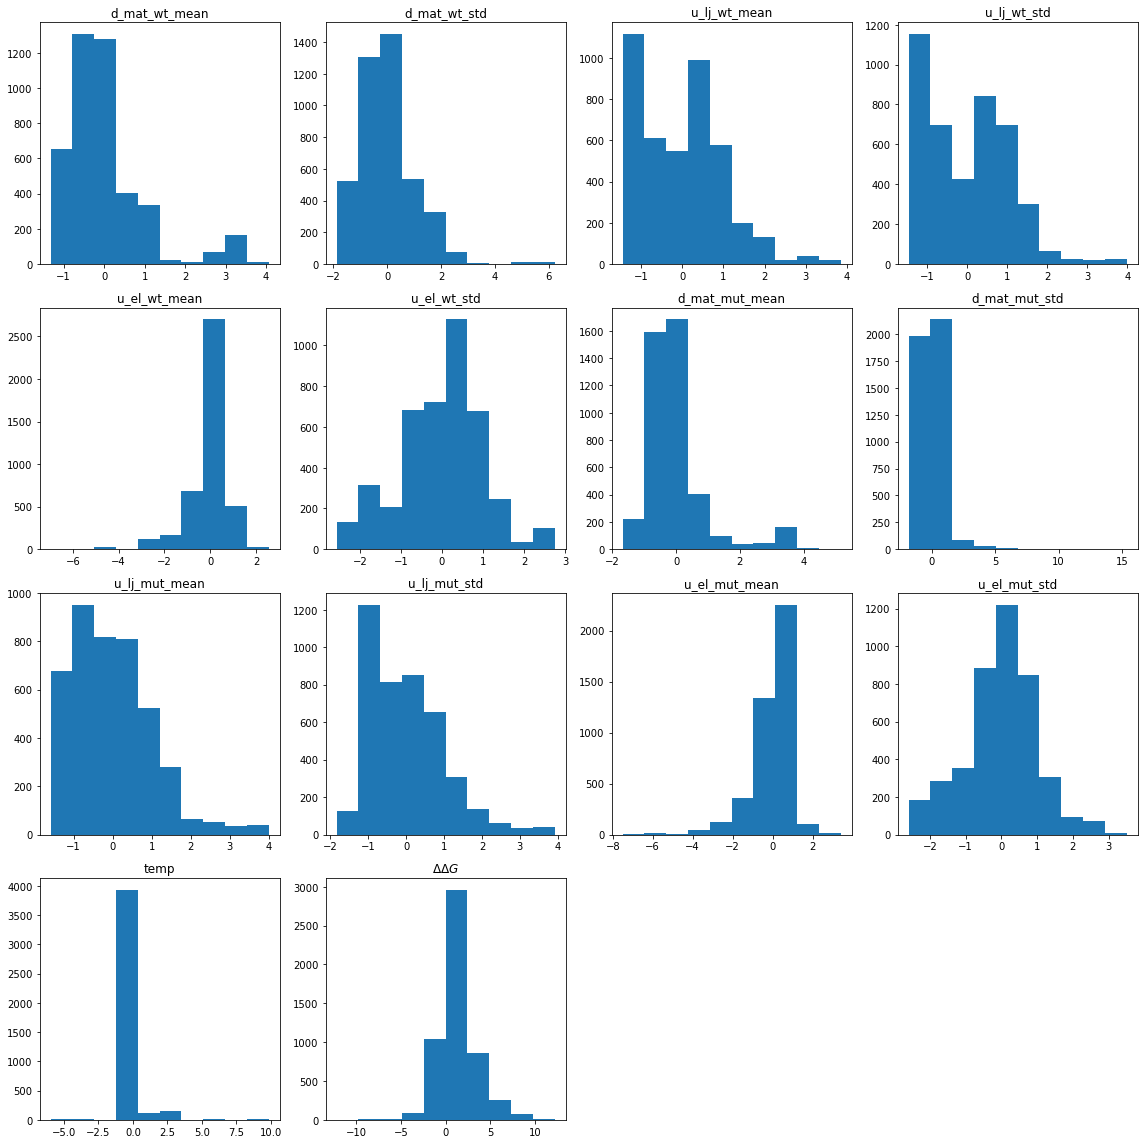

In [54]:
from matplotlib import pylab as plt
fig = plt.figure(figsize=(16,16))

N = len(mlp_features_columns)
Nsqrt = int(np.sqrt(N)+0.5)
for i in range(1, N-1):
    fig.add_subplot(Nsqrt, Nsqrt, i)
    plt.hist(x_train[:, i])
    plt.title(mlp_features_columns[i])
fig.add_subplot(Nsqrt, Nsqrt, N-1)
plt.hist(y)
plt.title('$\Delta\Delta G$')

fig.tight_layout()
plt.savefig('mlp_features.png')
plt.show()

In [55]:
# u_lj_mut_mean
sulj = np.sort(X[:, 8])
print(sulj[:50])
print('------------------------------------------------------------------------')
print(sulj[-50:])

[1.0000000e+08 1.0000000e+08 1.1811210e+08 1.2835631e+08 1.8011027e+08
 2.2859688e+08 2.4302322e+08 2.4408126e+08 2.5812794e+08 2.7120733e+08
 2.7596506e+08 2.7706611e+08 2.7980560e+08 2.8106387e+08 2.8964394e+08
 2.9378864e+08 2.9405846e+08 2.9749674e+08 2.9802797e+08 3.0201165e+08
 3.0394406e+08 3.0427811e+08 3.0731802e+08 3.1022426e+08 3.1174541e+08
 3.1191888e+08 3.1257814e+08 3.1273395e+08 3.1476800e+08 3.1567309e+08
 3.1822333e+08 3.1934714e+08 3.1941062e+08 3.2093366e+08 3.2205062e+08
 3.2245779e+08 3.2250109e+08 3.2595123e+08 3.2963533e+08 3.3275763e+08
 3.3341581e+08 3.3610202e+08 3.3634259e+08 3.3679661e+08 3.4005165e+08
 3.4063434e+08 3.4191907e+08 3.4210288e+08 3.4223795e+08 3.4283123e+08]
------------------------------------------------------------------------
[4.3439667e+09 4.3630259e+09 4.3868969e+09 4.3969623e+09 4.4157297e+09
 4.4225121e+09 4.4972390e+09 4.5376154e+09 4.5526083e+09 4.5580488e+09
 4.5679718e+09 4.5881037e+09 4.6267715e+09 4.6456837e+09 4.6472888e+09
 4.

In [56]:
# u_lj_mut_std
sulj = np.sort(X[:, 9])
print(sulj[:50])
print('------------------------------------------------------------------------')
print(sulj[-50:])

[1.6014123e+08 8.0908301e+08 1.3645549e+09 1.4535834e+09 1.9082806e+09
 2.2580173e+09 2.5190996e+09 2.8086838e+09 2.8440896e+09 2.9842179e+09
 3.0818414e+09 3.1387415e+09 3.2927841e+09 3.4363218e+09 3.5477371e+09
 3.7809357e+09 3.8748091e+09 3.8770778e+09 4.0147092e+09 4.0357760e+09
 4.0695926e+09 4.0772595e+09 4.0805681e+09 4.1109862e+09 4.1151588e+09
 4.1187226e+09 4.1267479e+09 4.1653832e+09 4.2052782e+09 4.2093204e+09
 4.2105574e+09 4.2222671e+09 4.2342182e+09 4.2647772e+09 4.2860792e+09
 4.2951434e+09 4.3256765e+09 4.3391933e+09 4.3436170e+09 4.3554171e+09
 4.3717612e+09 4.3798077e+09 4.3900365e+09 4.3935565e+09 4.3947203e+09
 4.4023096e+09 4.4174029e+09 4.4228081e+09 4.4245760e+09 4.4373903e+09]
------------------------------------------------------------------------
[4.5133881e+10 4.5137170e+10 4.5296194e+10 4.5376242e+10 4.5397459e+10
 4.5423915e+10 4.5582918e+10 4.5958889e+10 4.5969183e+10 4.6053958e+10
 4.6251561e+10 4.6399382e+10 4.6414787e+10 4.6462136e+10 4.6484218e+10
 4.

## MLP initial parameters

In [57]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, layers, nodes, dropout=0.0, do_batchnorm=False, output_dim=1):
        super().__init__()
        self.input = nn.Linear(input_dim, nodes)
        self.hidden = nn.ModuleList()
        self.dropout = nn.ModuleList()
        self.do_batchnorm = do_batchnorm
        if do_batchnorm:
            self.batchnorm = nn.ModuleList()
        for _ in range(layers):
            self.hidden.append(nn.Linear(nodes, nodes))
            self.dropout.append(nn.Dropout(dropout))
            if do_batchnorm:
                self.batchnorm.append(nn.BatchNorm1d(nodes))
        self.out = nn.Linear(nodes, output_dim)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.input(x)
        x = self.relu(x)

        for i, layer in enumerate(self.hidden):
            x = self.relu(layer(x))
            if self.do_batchnorm:
                x = self.dropout[i](self.batchnorm[i](x))
            else:
                x = self.dropout[i](x)

        return self.out(x)

In [129]:
model = MLP(
    input_dim=13,
    layers=64,
    nodes=60,
    dropout=0.2,
    do_batchnorm=False,
    output_dim=1
)

In [130]:
for p in model.hidden[0].parameters():
    print(p)
    print(p.shape)

Parameter containing:
tensor([[ 0.0579,  0.1175, -0.0812,  ..., -0.0015, -0.0718, -0.0492],
        [-0.0589,  0.0753, -0.0920,  ...,  0.0632, -0.0323, -0.1272],
        [ 0.1244,  0.0119,  0.1167,  ...,  0.0282,  0.0552, -0.0342],
        ...,
        [-0.1073,  0.0307,  0.0289,  ..., -0.0267,  0.1087,  0.0589],
        [ 0.1222, -0.1022,  0.0019,  ..., -0.0962,  0.0987,  0.1203],
        [ 0.0251, -0.0063, -0.0054,  ...,  0.1052,  0.0912,  0.1129]],
       requires_grad=True)
torch.Size([60, 60])
Parameter containing:
tensor([ 0.0933, -0.0810, -0.1061, -0.0979,  0.0204, -0.0942, -0.0665,  0.0157,
        -0.0769, -0.0845,  0.1159,  0.0661,  0.0506, -0.0623, -0.0469, -0.0345,
         0.0496, -0.0165,  0.0924, -0.1006,  0.0532, -0.0855,  0.0873,  0.1217,
        -0.0771,  0.0235, -0.0475,  0.0927, -0.1084,  0.1066,  0.0259,  0.0436,
         0.0877, -0.0172,  0.0921, -0.0986, -0.0017,  0.0615,  0.1266, -0.0954,
         0.0420, -0.0669, -0.0610,  0.0104,  0.0756,  0.0219, -0.0609,  0.

In [131]:
min_W = 1e10
max_W = -1e10
min_b = 1e10
max_b = -1e10
for layer in model.hidden:
    param_iter = layer.parameters()
    W = next(param_iter).detach().numpy()
    b = next(param_iter).detach().numpy()
    if np.max(W) > max_W:
        max_W = np.max(W)
    if np.min(W) < min_W:
        min_W = np.min(W)
    if np.max(b) > max_b:
        max_b = np.max(b)
    if np.min(b) < min_b:
        min_b = np.min(b)
print(f'max weight: {max_W:12.5}    min weight: {min_W:12.5}')
print(f'max bias:   {max_b:12.5}    min bias:   {min_b:12.5}')

max weight:       0.1291    min weight:      -0.1291
max bias:        0.12908    min bias:       -0.12892


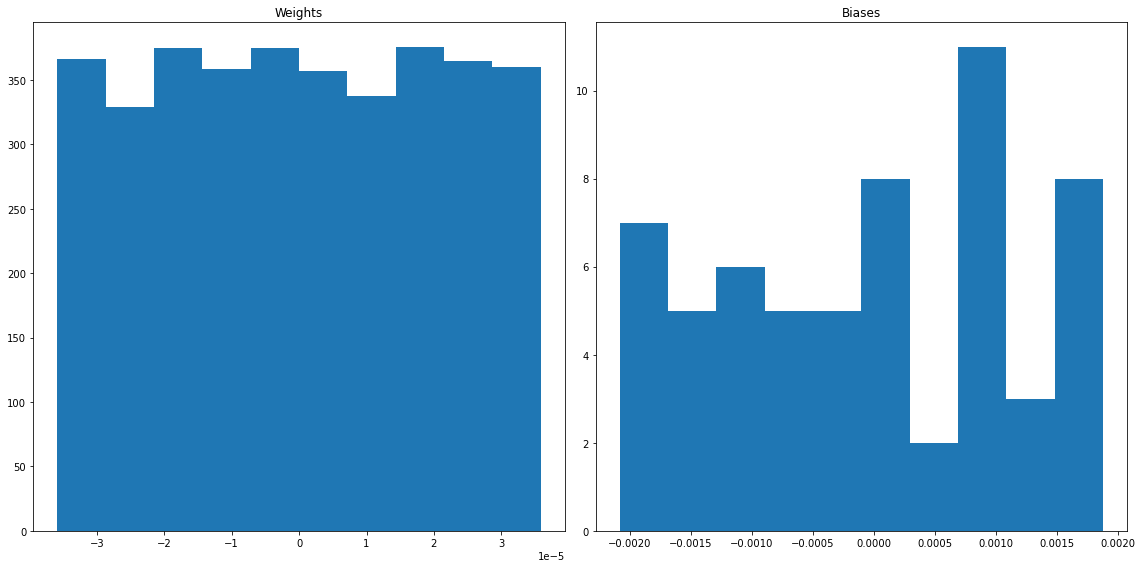

In [132]:
fig = plt.figure(figsize=(16,8))

# weights
fig.add_subplot(1, 2, 1)
plt.hist(W.ravel() / W.size, bins=10)
plt.title('Weights')

# biases
fig.add_subplot(1, 2, 2)
plt.hist(b / b.size, bins=10)
plt.title('Biases')

fig.tight_layout()
plt.savefig('mlp_init_params.png')
plt.show()

## MLP overfitting

In this section we explore how different amounts of nodes per hidden layer lead to overfitting in the model. We perform an analysis on the layers as well.

In [ ]:
def train(model, criterion, dataset_train, dataset_test, optimizer,
          n_epochs, device, test_metrics, best_heuristic=lambda x, y: True):
    """
    Trains the given model according to a certain criterion and logging
    the given test metrics.

    Parameters
    ----------
    model : torch.nn.Module
        model to be trained
    criterion : torch.nn._Loss
        criterion to use for training (for ex.: RMSE)
    dataset_train : DataLoader
        dataset used for training
    dataset_test : DataLoader
        dataset used for testing/validation
    optimizer : torch.optim.Optimizer
        optimizer to use for training (for ex.: Adam)
    n_epochs : int
        max number of consecutive epochs allowed without achieving a
        better evaluation score
    device : torch.device
        device to use for training (for ex.: CPU or CUDA)
    test_metrics : dict
        python dictionary with keys equal to the name of the test metric
        to use and values equal functions of the form:
        
            fun(y_real, y_pred) -> float
            
    best_heuristic : lambda function
        lambda function of the form:
        
            lambda x, y -> boolean
        
        The inputs are the overall best evaluation scores and 
        the current epoch's evaluation scores.
        If the output is `True`, the current evaluation score
        replaces the overall one. Otherwise, no change is
        performed.
        By default, this function always returns `True`.

    Returns
    -------
    train_loss : float
        final train loss
    eval_scores : dict
        final test scores/losses
    """
    print("Starting training")
    
    best_eval  = None
    best_epoch = 0
    best_train = None
    
    best_counter = 0
    epoch = -1
    while best_counter < n_epochs:
        best_counter += 1
        epoch += 1
        
        # Train an epoch
        model.train()
        train_losses = []
        # TODO: add batchnorm and dropout
        for batch_x, batch_y in dataset_train:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Evaluate the network (forward pass)
            logits = model.forward(batch_x)
            loss = criterion(logits, batch_y)
            train_losses.append(loss.item())

            # Compute the gradient
            optimizer.zero_grad()
            loss.backward()

            # Update the parameters of the model with a gradient step
            optimizer.step()

        train_loss = np.mean(train_losses)

        # Test the quality on the test set
        model.eval()
        eval_scores = {key: [] for key in test_metrics}
        n = 0
        for batch_x, batch_y in dataset_test:
            # to device
            batch_x = batch_x.to(device)

            # Evaluate the network (forward pass)
            # TODO: solve allocation error in GPU
            prediction = model(batch_x)

            # back to host
            prediction = prediction.cpu()

            # fix tensors to be used with test metrics
            # detach() excludes the tensor in the backprop caluclation
            prediction = prediction.detach().numpy().ravel()
            batch_y = batch_y.detach().numpy().ravel()

            # weighted sum of scores according to batch_y length
            for key, fun in test_metrics.items():
                eval_scores[key].append(
                    len(batch_y)*fun(batch_y, prediction)
                )

            n += len(batch_y)

        eval_scores = {key: sum(eval_scores[key])/n for key in test_metrics}
        
        if best_eval is None or best_heuristic(best_eval, eval_scores):
            best_eval  = eval_scores
            best_epoch = epoch
            best_train = train_loss
            best_counter = 0
        
        if epoch%5==0:
            eval_scores_str = \
                ' '.join([f'{k}={v:12.5g}' for k, v in eval_scores.items()])
            print("Epoch {} | Train loss: {:12.5g} Test scores: {}".format(
                epoch, train_loss, eval_scores_str))
    
    
    eval_scores_str = \
        ' '.join([f'{k}={v:12.5g}' for k, v in best_eval.items()])
    print("BEST - Epoch {} | Train loss: {:12.5g} Test scores: {}".format(
        best_epoch, best_train, eval_scores_str))
    return best_train, best_eval

these are the variables we will be storing in memory. Further down we will also store them in `pkl` format for ease reuse.

In [71]:
if not 'all_train_layers' in globals():
    all_train_layers  = {}
if not 'all_scores_layers' in globals():
    all_scores_layers = {}
if not 'all_train_nodes' in globals():
    all_train_nodes   = {}
if not 'all_scores_nodes' in globals():
    all_scores_nodes  = {}

this is the main cross validation section. By default, it performs the analysis over the number of nodes, fixing the number of layers to `8`.

To perform the analysis on the number of layers as well, this cell has to be re-run with:
```python
n_hidden_layers = [2, 4, 6, 8, 10]
n_hidden_nodes = [128]
```

In [150]:
import warnings
from scipy.stats import PearsonRConstantInputWarning
import time
warnings.simplefilter("ignore", PearsonRConstantInputWarning)

# hyperparameters #
## CHANGE VALUES HERE ##
n_hidden_layers = [8]
n_hidden_nodes = [16, 32, 64, 128, 256, 512]
########################
learning_rates = [1e-3]
dropouts = [0.25]  
batchnorm = [False]
L2 = [0.0]
batch_size = 512
hyperparam_space = itertools.product(
    n_hidden_layers, n_hidden_nodes, learning_rates, dropouts, batchnorm, L2)
kf = KFold(n_splits=10)
epochs = 300
opt_val_score = None

best_heuristic = lambda x, y: y['MSE'] < x['MSE']

str1=[]
str2=[]

start_t = time.time()

for params in hyperparam_space:
    print('\nhidden layers: {}, nodes per layer: {}, learning rate: {}, dropout: {}, do batchnorm: {}, L2: {}\t'.format(
        params[0], params[1], params[2], params[3], params[4], params[5]))
    # K-fold cross validation
    train_losses_kf = []
    val_scores_kf = {key: [] for key in test_metrics}
    k = 0
    for train_index, val_index in kf.split(x_train):
        print(f'k-fold: {k}')
        
        # None adds a new axis
        x_kftrain, y_kftrain = \
            x_train[train_index], y_train[train_index, None]
        x_kfval, y_kfval = \
            x_train[val_index], y_train[val_index, None]

        dataset_kftrain = gen_loaders(x_kftrain, y_kftrain, batch_size)
        dataset_kfval = gen_loaders(x_kfval, y_kfval, batch_size)

        model = MLP(
            input_dim=x_train.shape[1],
            layers=params[0],
            nodes=params[1],
            dropout=params[3],
            do_batchnorm=params[4],
            output_dim=1
        ).to(device)

        optimizer = torch.optim.Adam(
            model.parameters(), lr=params[2], weight_decay=params[5])

        train_loss, val_scores = \
            train(model, criterion, dataset_kftrain, dataset_kfval,
                  optimizer, epochs, device, test_metrics, best_heuristic)

        train_losses_kf.append(train_loss)
        for key, fun in test_metrics.items():
            val_scores_kf[key].append(val_scores[key])
        k += 1
        
    mean_train_loss = np.mean(train_losses_kf)
    mean_val_scores = {key:
                       np.mean(val_scores_kf[key]) for key in test_metrics}
    std_val_scores = {key:
                       np.std(val_scores_kf[key]) for key in test_metrics}

    # for line plot
    all_scores_layers[params[0]] = val_scores_kf
    all_train_layers[params[0]] = train_losses_kf
    all_scores_nodes[params[1]] = val_scores_kf
    all_train_nodes[params[1]] = train_losses_kf


    # output
    print(f'R={mean_val_scores["pearsonr"]} R std={std_val_scores["pearsonr"]} MSE={mean_val_scores["MSE"]} MSE std={std_val_scores["MSE"]}')
    print(
        f'hyperparams.:{str(params)} with validation score={mean_val_scores["pearsonr"]:12.5}')
    str1.append(f'R={mean_val_scores["pearsonr"]} R std={std_val_scores["pearsonr"]} MSE={mean_val_scores["MSE"]} MSE std={std_val_scores["MSE"]}')
    str2.append(f'hyperparams.:{str(params)} with validation score={mean_val_scores["pearsonr"]:12.5}')

    # best hyperparameters
    if opt_val_score is None \
            or mean_val_scores['pearsonr'] > opt_val_score:
        opt_val_score = mean_val_scores['pearsonr']
        opt_params = params

end_t = time.time()

print(
    f'best hyperparams.:{str(opt_params)} with validation score={opt_val_score:12.5} in {end_t-start_t}s')

print()
for i, s in enumerate(str1):
    print(s)
    print(str2[i])


hidden layers: 8, nodes per layer: 32, learning rate: 0.001, dropout: 0.25, do batchnorm: False, L2: 0.0	
k-fold: 0
Starting training
Epoch 0 | Train loss:       6.1882 Test scores: pearsonr=    0.020182 MSE=      6.9584 RMSE=      2.6379
Epoch 5 | Train loss:       5.0642 Test scores: pearsonr=    0.066743 MSE=      5.2181 RMSE=      2.2843
Epoch 10 | Train loss:       4.8523 Test scores: pearsonr=     0.20181 MSE=      5.2183 RMSE=      2.2844
Epoch 15 | Train loss:       4.7452 Test scores: pearsonr=     0.22074 MSE=      5.1498 RMSE=      2.2693
Epoch 20 | Train loss:       4.6378 Test scores: pearsonr=     0.22939 MSE=      5.0768 RMSE=      2.2532
Epoch 25 | Train loss:       4.5774 Test scores: pearsonr=      0.2396 MSE=       5.064 RMSE=      2.2503
Epoch 30 | Train loss:       4.3715 Test scores: pearsonr=     0.27755 MSE=      4.8438 RMSE=      2.2009
Epoch 35 | Train loss:       4.3072 Test scores: pearsonr=     0.33293 MSE=       4.728 RMSE=      2.1744
Epoch 40 | Train lo

### box plots

analysis on nodes,

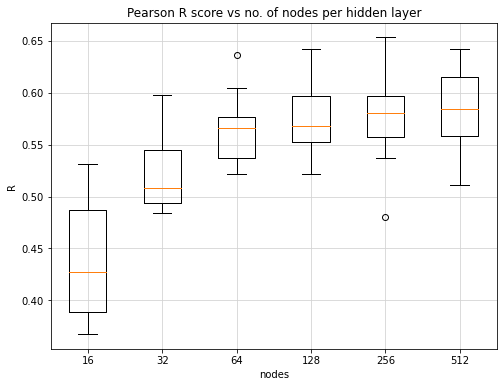

In [151]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
data = []
for nodes in all_scores_nodes:
    data.append(all_scores_nodes[nodes]['pearsonr'])
ax.boxplot(data, labels=[f'{k}' for k in all_scores_nodes.keys()])
# ax.set_facecolor('aliceblue')
ax.set_xlabel('nodes')
ax.set_ylabel('R')
plt.title('Pearson R score vs no. of nodes per hidden layer')
plt.grid(color='lightgray')
plt.savefig('mlp_R_vs_nodes.png')
plt.show()

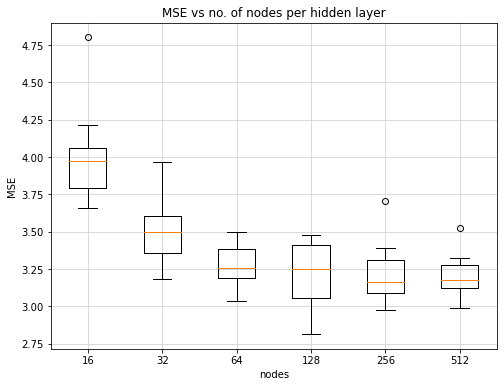

In [152]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
data = []
for nodes in all_scores_nodes:
    data.append(all_scores_nodes[nodes]['MSE'])
ax.boxplot(data, labels=[f'{k}' for k in all_scores_nodes.keys()])
# ax.set_facecolor('aliceblue')
ax.set_xlabel('nodes')
ax.set_ylabel('MSE')
plt.title('MSE vs no. of nodes per hidden layer')
plt.grid(color='lightgray')
plt.savefig('mlp_MSE_vs_nodes.png')
plt.show()

\
analysis on layers,

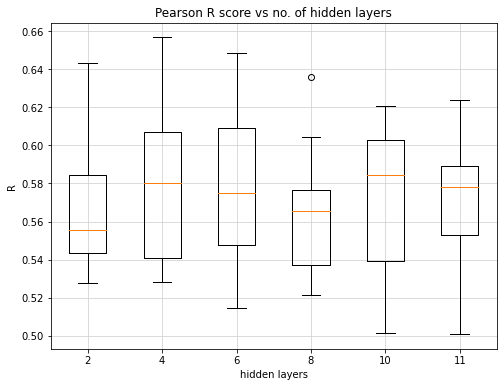

In [158]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
data = []
for nodes in all_scores_layers:
    data.append(all_scores_layers[nodes]['pearsonr'])
ax.boxplot(data, labels=[f'{k}' for k in all_scores_layers.keys()])
# ax.set_facecolor('aliceblue')
ax.set_xlabel('hidden layers')
ax.set_ylabel('R')
plt.title('Pearson R score vs no. of hidden layers')
plt.grid(color='lightgray')
plt.savefig('mlp_R_vs_layers.png')
plt.show()

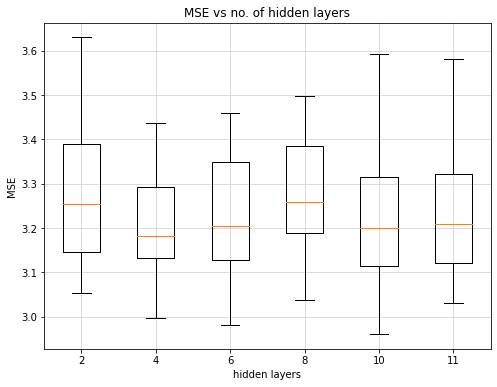

In [159]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
data = []
for nodes in all_scores_layers:
    data.append(all_scores_layers[nodes]['MSE'])
ax.boxplot(data, labels=[f'{k}' for k in all_scores_layers.keys()])
# ax.set_facecolor('aliceblue')
ax.set_xlabel('hidden layers')
ax.set_ylabel('MSE')
plt.title('MSE vs no. of hidden layers')
plt.grid(color='lightgray')
plt.savefig('mlp_MSE_vs_layers.png')
plt.show()

### save data

In [77]:
import pandas as pd
import pickle

def save_data(nodes_tr, nodes_val, layers_tr, layers_val):
    """Save data to `mlp_overfit_data.pkl` in PKL format."""
    f = open("mlp_overfit_data.pkl","wb")
    data = {'nodes_tr': nodes_tr, 'nodes_val': nodes_val, 'layers_tr':layers_tr, 'layers_val':layers_val}
    pickle.dump(data,f)
    f.close()
    
def load_data():
    """Load data from `mlp_overfit_data.pkl`"""
    data = pd.read_pickle('mlp_overfit_data.pkl')
    nodes_tr, nodes_val, layers_tr, layers_val = data['nodes_tr'], data['nodes_val'], data['layers_tr'], data['layers_val']
    return nodes_tr, nodes_val, layers_tr, layers_val

\
please use this two cells to save the data each time you perform a cross-validation run:

In [155]:
save_data(all_train_nodes, all_scores_nodes, all_train_layers, all_scores_layers)

In [156]:
nodes_tr, nodes_val, layers_tr, layers_val = load_data()

### line plots

analysis on nodes,

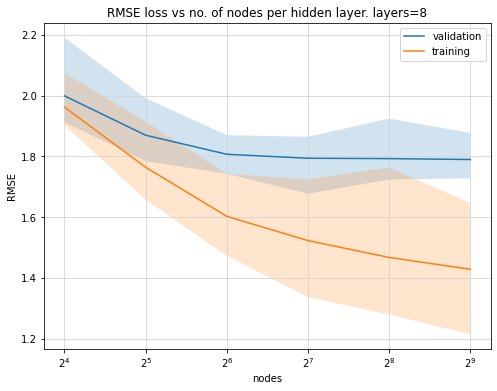

In [157]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
ax.set_xscale('log', base=2)
val_data = []
nodes = []
for n in nodes_val:
    val_data.append(np.sqrt(nodes_val[n]['MSE']))
    nodes.append(n)
mval_data = np.mean(val_data, axis=1)
ax.plot(nodes, mval_data, label='validation')
stdval_data = np.std(val_data, axis=1)
# ax.fill_between(nodes, mval_data-stdval_data, mval_data+stdval_data, alpha=0.2)
ax.fill_between(nodes, 
                np.min(val_data, axis=1),
                np.max(val_data, axis=1), 
                alpha=0.2)

train_data = [np.sqrt(v) for v in nodes_tr.values()]
mtrain_data = np.mean(train_data, axis=1)
ax.plot(nodes, mtrain_data, label='training')
stdtrain_data = np.std(val_data, axis=1)
# ax.fill_between(nodes, mtrain_data-stdtrain_data, mtrain_data+stdtrain_data, alpha=0.2)
ax.fill_between(nodes, 
                np.min(train_data, axis=1),
                np.max(train_data, axis=1), 
                alpha=0.2)

ax.set_xlabel('nodes')
ax.set_ylabel('RMSE')
ax.legend()
plt.title(f'RMSE loss vs no. of nodes per hidden layer. layers={n_hidden_layers[0]}')
plt.grid(color='lightgray')

plt.savefig(f'mlp_RMSE_vs_nodes_lineplot_{n_hidden_layers[0]}layers.png')
plt.show()

\
analysis on layers,

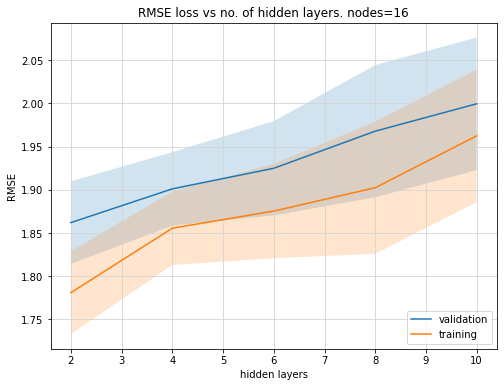

In [131]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
val_data = []
layers = []
for n in layers_val:
    val_data.append( np.sqrt(layers_val[n]['MSE']) )
    layers.append(n)
mval_data = np.mean(val_data, axis=1)
ax.plot(layers, mval_data, label='validation')
stdval_data = np.std(val_data, axis=1)
ax.fill_between(layers, mval_data-stdval_data, mval_data+stdval_data, alpha=0.2)

train_data = [ np.sqrt(v) for v in layers_tr.values()]
mtrain_data = np.mean(train_data, axis=1)
ax.plot(layers, mtrain_data, label='training')
stdtrain_data = np.std(val_data, axis=1)
ax.fill_between(layers, mtrain_data-stdtrain_data, mtrain_data+stdtrain_data, alpha=0.2)

ax.set_xlabel('hidden layers')
ax.set_ylabel('RMSE')
ax.legend(loc='lower right')
plt.title(f'RMSE loss vs no. of hidden layers. nodes={n_hidden_nodes[0]}')
plt.grid(color='lightgray')

plt.savefig('mlp_RMSE_vs_layers_lineplot.png')
plt.show()

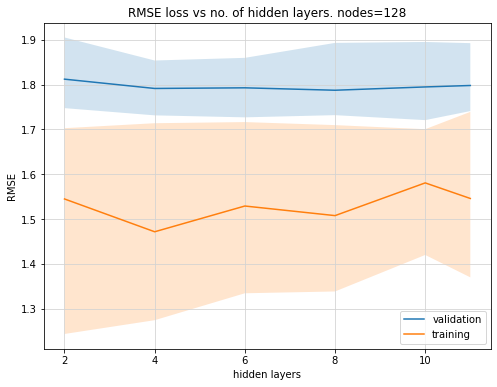

In [143]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
val_data = []
layers = []
for n in layers_val:
    val_data.append( np.sqrt(layers_val[n]['MSE']) )
    layers.append(n)
mval_data = np.mean(val_data, axis=1)
ax.plot(layers, mval_data, label='validation')
stdval_data = np.std(val_data, axis=1)
ax.fill_between(layers, 
                np.min(val_data, axis=1),
                np.max(val_data, axis=1), 
                alpha=0.2)

train_data = [ np.sqrt(v) for v in layers_tr.values()]
mtrain_data = np.mean(train_data, axis=1)
ax.plot(layers, mtrain_data, label='training')
stdtrain_data = np.std(val_data, axis=1)
ax.fill_between(layers, 
                np.min(train_data, axis=1),
                np.max(train_data, axis=1), 
                alpha=0.2)

ax.set_xlabel('hidden layers')
ax.set_ylabel('RMSE')
ax.legend(loc='lower right')
plt.title(f'RMSE loss vs no. of hidden layers. nodes={n_hidden_nodes[0]}')
plt.grid(color='lightgray')

plt.savefig(f'mlp_RMSE_vs_layers_lineplot_{n_hidden_nodes[0]}nodes.png')
plt.show()

## HydraNet

In [ ]:
df_test = pd.read_csv(skempi_csv, sep=';')
# df = df.iloc[:4096, :]

# filter duplicated
df_test = df_test[~df_test.duplicated(subset=["#Pdb", "Mutation(s)_cleaned"])]

# remove without target
df_test = df_test.dropna(subset=['Affinity_mut_parsed'])
df_test = df_test.dropna(subset=['Affinity_wt_parsed'])
df_test = df_test.dropna(subset=['Temperature'])

pdb_n = 0
name_wt = df_test.iloc[pdb_n,0]

test_dmat = np.load(wt_features_path + 'D_mat/' + name_wt + '.npy')

test_lj = np.load(wt_features_path + 'U_LJ/' + name_wt + '.npy')

test_el = np.load(wt_features_path + 'U_el/' + name_wt + '.npy')

print('u_dmat sample ranges: ', test_dmat.min(), '\t', test_dmat.max())
print('u_lj sample ranges: ', test_lj.min(), '\t', test_lj.max())
print('u_el sample ranges: ', test_el.min(), '\t', test_el.max())
# test_el.min()

fig = plt.figure()

fig.add_subplot(221)
plt.hist(np.log(test_lj.flatten() - test_lj.min() + 1))
plt.title('log normalized lj potentials')

fig.add_subplot(222)
plt.hist(test_el.flatten())
plt.title('electrostatic potentials')

fig.add_subplot(223)
plt.hist(test_dmat.flatten())
plt.title('pairwise distances')

fig.tight_layout()

In [ ]:
name_wt = '1A22_A_B'
name_mut = '1A22_A_B_NB31A'

def standardize(arr):
    return (arr - np.mean(arr)) / np.std(arr)

def normalize_range(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

def log_standardize(arr):
    temp = np.log(arr - arr.min() + 1)
    return standardize(temp)

def log_normalize(arr):
    temp = np.log(arr - arr.min() + 1)
    return normalize(temp)

wt_arr = np.load(wt_features_path + name_wt + '.npy')

wt_arr[0] = log_standardize(np.clip(wt_arr[0], None, 1e12))
wt_arr[1] = standardize(wt_arr[1])
wt_arr[2] = standardize(wt_arr[2])

print('n entries outside of [0,1] range: ', np.sum(np.logical_or(wt_arr < 0, wt_arr > 1)))

# wt_arr[0] = normalize_range(wt_arr[0])
# wt_arr[1] = normalize_range(wt_arr[1])
# wt_arr[2] = normalize_range(wt_arr[2])

mut_arr = np.load(mut_features_path + name_mut + '.npy')

mut_arr[0] = log_standardize(np.clip(mut_arr[0], None, 1e12))
mut_arr[1] = standardize(mut_arr[1])
mut_arr[2] = standardize(mut_arr[2])



# mut_arr[0] = normalize_range(mut_arr[0])
# mut_arr[1] = normalize_range(mut_arr[1])
# mut_arr[2] = normalize_range(mut_arr[2])


fig = plt.figure(figsize=(5, 12))

fig.add_subplot(221)
plt.imshow(wt_arr.transpose(1, 2, 0))
plt.title(f'{name_wt}')

fig.add_subplot(222)
plt.imshow(mut_arr.transpose(1, 2, 0))
plt.title(f'{name_mut}')

plt.tight_layout()
# wt_arr.shape
print('wt max: ', wt_arr.max(), '\t mut max: ', mut_arr.max(),
      'wt min: ', wt_arr.min(), '\t mut min: ', mut_arr.min())